In [62]:
wsizes = [25,50,100] #,250,500]
with open("../misc_files/scaffolds.2.5Mb.txt","r") as fh:
    scaffolds = [line.strip() for line in fh]

In [63]:
l = []
for scaf in scaffolds:
    print(scaf)
    for ws in wsizes:
        fh = "../feat_dist/{}.{}.tab.gz".format(ws, scaf)
        df = pd.read_csv(fh, sep="\t", header=None)
        df.columns = ["scaf", "start", "end", "rrate", "hmm", "cpgplot", "both","ws"]
        l.append(df)
d = pd.concat(l)

Super_scaffold_1
Super_scaffold_2
Super_scaffold_3
Super_scaffold_4
Super_scaffold_6
Super_scaffold_141


FileNotFoundError: [Errno 2] No such file or directory: '../feat_dist/25.Super_scaffold_141.tab.gz'

In [1]:
d = pd.read_csv("../feat_dist/merged.tab.gz", header=None, sep="\t", compression="gzip")
d.columns = ["scaf", "start", "end", "rrate", "hmm", "cpgplot", "both", "ws"]
d = d.replace(-1, np.nan)

In [5]:
# List of features
features_to_bin = ["cpgplot","hmm","both"]
binned_features = ["binned_{}".format(f) for f in features_to_bin]
rmaps = ["rrate"]

# Length in base-pairs of the windows
wl = 100

# Bin the distance measures
for feature in features_to_bin:
    d["binned_"+feature] = [round(x/wl)*wl if x>=0 else x for x in d[feature]]

In [6]:
def boot(df, rounds, bottom, upper, func, norm):

    #CI by bootstrap
    boots = []
    
    for r in range(rounds):
        rdf = df.sample(n=len(df), replace=True)
        boots.append(func(rdf))
        
    return_df = pd.DataFrame([np.percentile(boots, bottom)/norm,
                              func(boots)/norm,
                              np.percentile(boots, upper)/norm
                             ]).transpose()
    return(return_df)
    
def rr_distance_to(d, norm_d, rmap, feature, limit, norm, func, boot_n):
    
    #value to normalise
    n = func(norm_d[rmap])
    
    #recombination rate with distance slices
    result = d[d[feature]<limit].groupby(feature)[rmap].apply(lambda x: boot(x, boot_n, 2.5, 97.5, np.nanmean, 1 if not norm else n))
    result = result.reset_index()
    result.columns = ["distance","feature","low_ci","midpoint","high_ci"]
    result.feature = feature
    result["rmap"] = rmap
    
    return result

In [7]:
features_l = []

for rmap in rmaps:
    for feature in binned_features:
        for ws,df in d.groupby("ws"):
            print(ws, feature)
            result_df = rr_distance_to(df, df[df[feature].between(15e3,20e3)], 
                                       rmap, feature, 20e3, True, np.nanmean, 10)
            result_df["ws"] = ws
            features_l.append(result_df)
            
features = pd.DataFrame(pd.concat(features_l))

25 binned_cpgplot
50 binned_cpgplot
100 binned_cpgplot
25 binned_hmm
50 binned_hmm
100 binned_hmm
25 binned_both
50 binned_both
100 binned_both


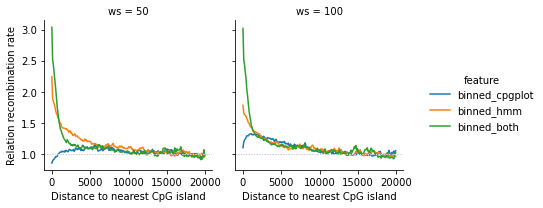

In [25]:
g = sns.FacetGrid(data=features[features.ws!=25], col="ws", hue="feature")
g.map(sns.lineplot, "distance", "midpoint")
g.add_legend()
g.map(plt.axhline, y=1, color="lightgray", linestyle="dotted", linewidth=1)
g.set_axis_labels("Distance to nearest CpG island", "Relation recombination rate")
g.tight_layout()
g.savefig("recomb_around_islands.pdf")